In [1]:
# Imports
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights, ResNet50_Weights, ResNet34_Weights
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Parameters
learning_rate = 0.001
batch_size = 128
epochs = 10
decisions_file_path = "/content/drive/MyDrive/data/sorted_decisions.csv"
images_path = "/content/drive/MyDrive/data/compressed_images"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device: {device}")


Selected device: cuda


In [4]:
# Dataset
class AssistantDataset(Dataset):
    def __init__(self, images_dir: str, labels_file: str, transform=None):
        self.images_dir = images_dir
        self.labels = pd.read_csv(labels_file)
        self.transform = transform or transforms.ToTensor()

        self.label_encoders = {
            "activity": LabelEncoder(),
            "hearts": LabelEncoder(),
            "light_lvl": LabelEncoder(),
            "in_hand_item": LabelEncoder(),
            "target_mob": LabelEncoder(),
        }

        for col in self.label_encoders:
            self.label_encoders[col].fit(self.labels[col])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_path = os.path.join(self.images_dir, self.labels.iloc[index, 0])
        image = Image.open(image_path).convert('RGB')

        heart_region = image.crop((215, 370, 400,  420))
        in_hand_region = image.crop((200, 410, 600,  450))

        if self.transform:
            image = self.transform(image)
            heart_region = self.transform(heart_region)
            in_hand_region = self.transform(in_hand_region)

        targets = {col: self.label_encoders[col].transform([self.labels.iloc[index][col]])[0]
                   for col in self.label_encoders}

        return image, heart_region, in_hand_region, targets


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
ds = AssistantDataset(images_dir=images_path, labels_file=decisions_file_path, transform=transform)
train_ds, valid_ds = random_split(ds, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=4)


In [6]:
# Calculate Class Weights
import numpy as np
class_weights = {}
for col, encoder in ds.label_encoders.items():
    labels = encoder.transform(ds.labels[col])
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights[col] = torch.tensor(weights, dtype=torch.float).to(device)


In [7]:
class_weights

{'activity': tensor([1.0347, 1.1258, 1.7723, 0.8592, 0.7979, 0.8592], device='cuda:0'),
 'hearts': tensor([30.6857, 25.5714,  2.9505,  8.5238,  0.4855,  4.1467,  0.6819,  1.1894,
          3.1312,  2.8413,  7.3061,  0.9355,  1.8050,  2.5152,  0.8620,  1.7048,
          2.8949,  5.4796,  1.1450,  2.4354,  0.1055], device='cuda:0'),
 'light_lvl': tensor([5.3522e-01, 1.1345e+00, 8.0070e-01, 8.0550e+02], device='cuda:0'),
 'in_hand_item': tensor([ 4.5767,  0.9969,  0.8203, 11.1875,  0.9153,  0.4289,  0.6383,  2.0868],
        device='cuda:0'),
 'target_mob': tensor([8.2194, 7.5457, 0.2245, 0.7017, 3.5960, 5.2305, 2.5152],
        device='cuda:0')}

In [8]:
# Model Metrics and Loss Functions
class ModelMetrics:
    def __init__(self, num_classes, class_weights):
        self.loss_fns = {key: nn.CrossEntropyLoss(weight=class_weights[key]) for key in num_classes}

    def calculate_loss(self, predictions, targets):
        total_loss = 0
        losses = {}
        for key, pred in predictions.items():
            target = targets[key].to(pred.device)
            loss = self.loss_fns[key](pred, target)
            losses[key] = loss.item()
            total_loss += loss
        return total_loss, losses

    def calculate_accuracy(self, predictions, targets):
        accuracies = {}
        for key, pred in predictions.items():
            target = targets[key].to(pred.device)
            acc = (pred.argmax(dim=1) == target).float().mean().item()
            accuracies[key] = acc
        return accuracies


In [9]:
class HeartsInHandClassifier(nn.Module):
    def __init__(self, hearts_classes, in_hand_classes):
        super(HeartsInHandClassifier, self).__init__()

        self.resnet_hearts = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet_in_hand = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        for param in list(self.resnet_hearts.parameters())[:6]:
            param.requires_grad = False
        for param in list(self.resnet_in_hand.parameters())[:6]:
            param.requires_grad = False

        self.resnet_hearts.fc = nn.Identity()
        self.resnet_in_hand.fc = nn.Identity()

        self.fc_hearts = nn.Linear(512, hearts_classes)
        self.fc_in_hand = nn.Linear(512, in_hand_classes)

    def forward(self, heart_region, in_hand_region):
        heart_features = self.resnet_hearts(heart_region)
        in_hand_features = self.resnet_in_hand(in_hand_region)

        hearts_pred = self.fc_hearts(heart_features)
        in_hand_pred = self.fc_in_hand(in_hand_features)

        return {"hearts": hearts_pred, "in_hand_item": in_hand_pred}


class ImageContextClassifier(nn.Module):
    def __init__(self, num_classes):
      super(ImageContextClassifier, self).__init__()
      self.cnn = models.resnet34(weights=ResNet34_Weights.DEFAULT)

      for param in list(self.cnn.parameters())[:6]:
          param.requires_grad = False
      for param in list(self.cnn.parameters())[6:]:
          param.requires_grad = True

      self.cnn.fc = nn.Identity()

      self.fc = nn.ModuleDict({
            key: nn.Linear(512, num) for key, num in num_classes.items() if key not in ["hearts", "in_hand_item"]
        })

    def forward(self, x):
        features = self.cnn(x)
        return {key: layer(features) for key, layer in self.fc.items()}


# Ensemble function to combine predictions from both models
def ensemble_predict(hearts_model, context_model, heart_region, in_hand_region, full_image):
    hearts_output = hearts_model(heart_region, in_hand_region)
    context_output = context_model(full_image)
    return {**hearts_output, **context_output}

In [10]:
# Training Setup
num_classes = {col: len(ds.label_encoders[col].classes_) for col in ds.label_encoders}
hearts_model = HeartsInHandClassifier(hearts_classes=num_classes["hearts"], in_hand_classes=num_classes["in_hand_item"]).to(device)
context_model = ImageContextClassifier(num_classes=num_classes).to(device)

# Define metrics and optimizer
metrics = ModelMetrics(num_classes, class_weights)
optimizer_hearts = optim.Adam(hearts_model.parameters(), lr=learning_rate)
optimizer_context = optim.Adam(context_model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 192MB/s]


In [11]:
# Training Loop
def fit(training_accuracies, validation_accuracies, training_losses, validation_losses, epochs):
    for epoch in range(epochs):
        hearts_model.train()
        context_model.train()

        total_loss_train = 0
        total_accuracies_train = {key: 0 for key in num_classes}

        # Training phase
        for images, heart_regions, in_hand_regions, targets in train_dl:
            images, heart_regions, in_hand_regions = images.to(device), heart_regions.to(device), in_hand_regions.to(device)
            targets = {key: val.to(device) for key, val in targets.items()}

            hearts_output = hearts_model(heart_regions, in_hand_regions)
            context_output = context_model(images)
            predictions = {**hearts_output, **context_output}
            loss, batch_losses = metrics.calculate_loss(predictions, targets)

            optimizer_hearts.zero_grad()
            optimizer_context.zero_grad()
            loss.backward()
            optimizer_hearts.step()
            optimizer_context.step()


            total_loss_train += loss.item()
            batch_accuracies = metrics.calculate_accuracy(predictions, targets)
            for key in total_accuracies_train:
                total_accuracies_train[key] += batch_accuracies[key]

        avg_loss = total_loss_train / len(train_dl)
        training_losses.append(avg_loss)
        avg_train_accuracies = {key: acc / len(train_dl) for key, acc in total_accuracies_train.items()}
        for key in training_accuracies:
            training_accuracies[key].append(avg_train_accuracies[key])

        print(f"[TRAIN] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
        print("Accuracies:", avg_train_accuracies)

        hearts_model.eval()
        context_model.eval()
        with torch.no_grad():
            total_loss_valid = 0
            total_accuracies_valid = {key: 0 for key in num_classes}

            for images, heart_regions, in_hand_regions, targets in valid_dl:
                images, heart_regions, in_hand_regions = images.to(device), heart_regions.to(device), in_hand_regions.to(device)
                targets = {key: val.to(device) for key, val in targets.items()}

                hearts_output = hearts_model(heart_regions, in_hand_regions)
                context_output = context_model(images)
                predictions = {**hearts_output, **context_output}

                loss, batch_losses = metrics.calculate_loss(predictions, targets)
                total_loss_valid += loss.item()

                batch_accuracies = metrics.calculate_accuracy(predictions, targets)
                for key in total_accuracies_valid:
                    total_accuracies_valid[key] += batch_accuracies[key]

            avg_loss_valid = total_loss_valid / len(valid_dl)
            validation_losses.append(avg_loss_valid)
            avg_valid_accuracies = {key: acc / len(valid_dl) for key, acc in total_accuracies_valid.items()}
            for key in validation_accuracies:
                validation_accuracies[key].append(avg_valid_accuracies[key])

            print(f"[VALID] Epoch {epoch+1}/{epochs} - Loss: {avg_loss_valid:.4f}")
            print("Accuracies:", avg_valid_accuracies)

In [12]:
training_accuracies = {key: [] for key in num_classes}
validation_accuracies = {key: [] for key in num_classes}
training_losses, validation_losses = [], []

fit(
    training_accuracies=training_accuracies,
    validation_accuracies=validation_accuracies,
    training_losses=training_losses,
    validation_losses=validation_losses,
    epochs=epochs
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x512 and 1024x21)

In [13]:
# Saving models
hearts_model.cpu()
context_model.cpu()
torch.save(hearts_model.state_dict(), "./hearts_model.pth")
torch.save(context_model.state_dict(), "./context_model.pth")

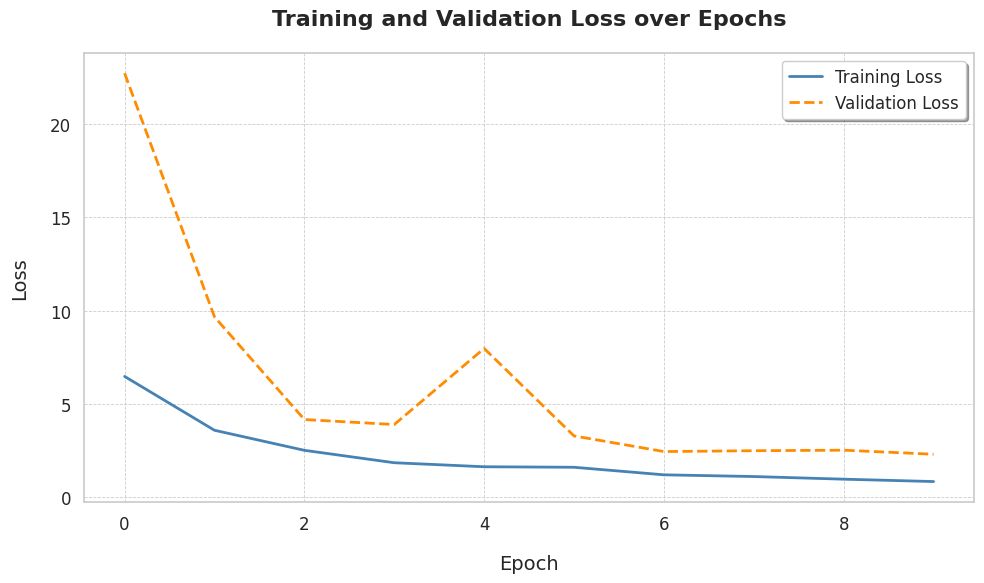

In [14]:
# Display loss
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label="Training Loss", color='steelblue', linestyle='-', linewidth=2)
plt.plot(validation_losses, label="Validation Loss", color='darkorange', linestyle='--', linewidth=2)

plt.xlabel("Epoch", fontsize=14, labelpad=15)
plt.ylabel("Loss", fontsize=14, labelpad=15)
plt.title("Training and Validation Loss over Epochs", fontsize=16, fontweight='bold', pad=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc="upper right", fontsize=12, frameon=True, shadow=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.6)
plt.tight_layout()

plt.savefig("training_validation_loss.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

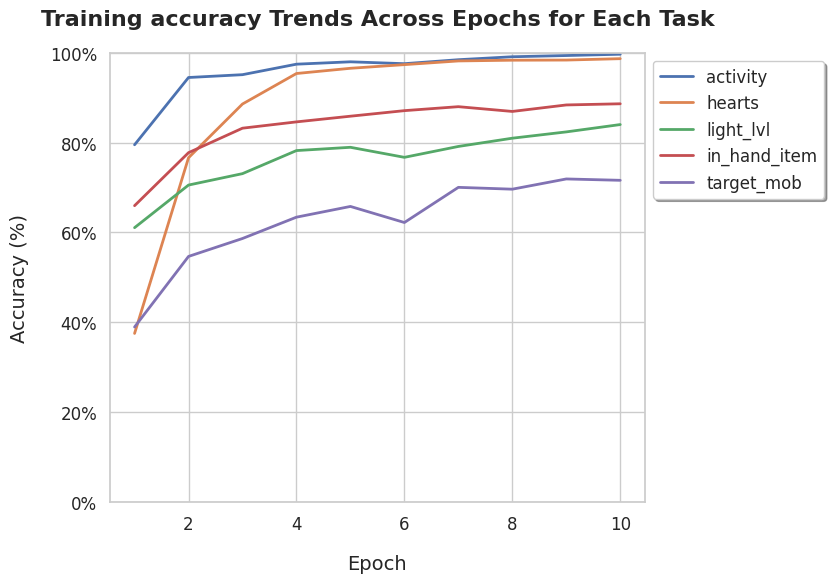

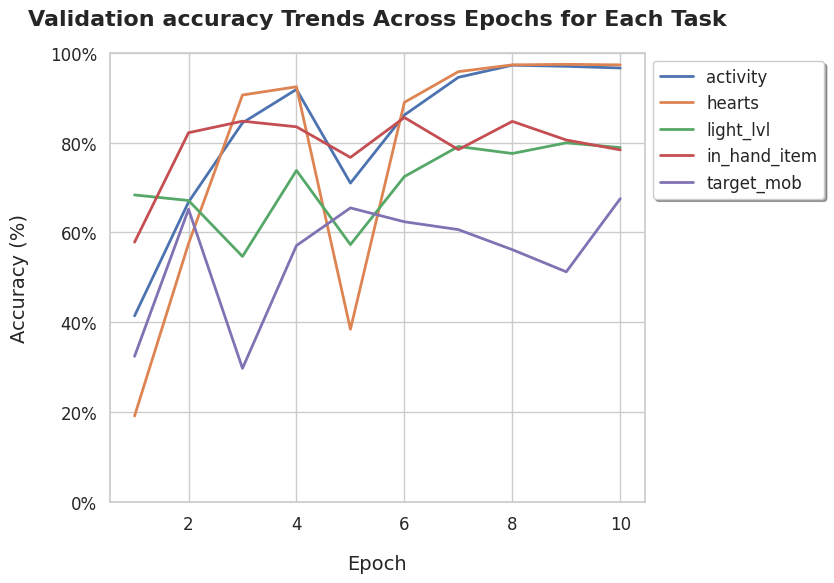

In [15]:
# Display accuracies V1
epochs = list(range(1, len(training_accuracies[next(iter(training_accuracies))]) + 1))

for name, accuracies in zip(("Training", "Validation"), (training_accuracies, validation_accuracies)):
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))

    for key, values in accuracies.items():
        plt.plot(epochs, values, label=key, linewidth=2)

    plt.title(f'{name} accuracy Trends Across Epochs for Each Task', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Epoch', fontsize=14, labelpad=15)
    plt.ylabel('Accuracy (%)', fontsize=14, labelpad=15)

    plt.ylim(0, 1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, frameon=True, shadow=True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.savefig(f"{name.lower()}_accuracy_trends.png", format='png', dpi=300, bbox_inches='tight')
    plt.show()

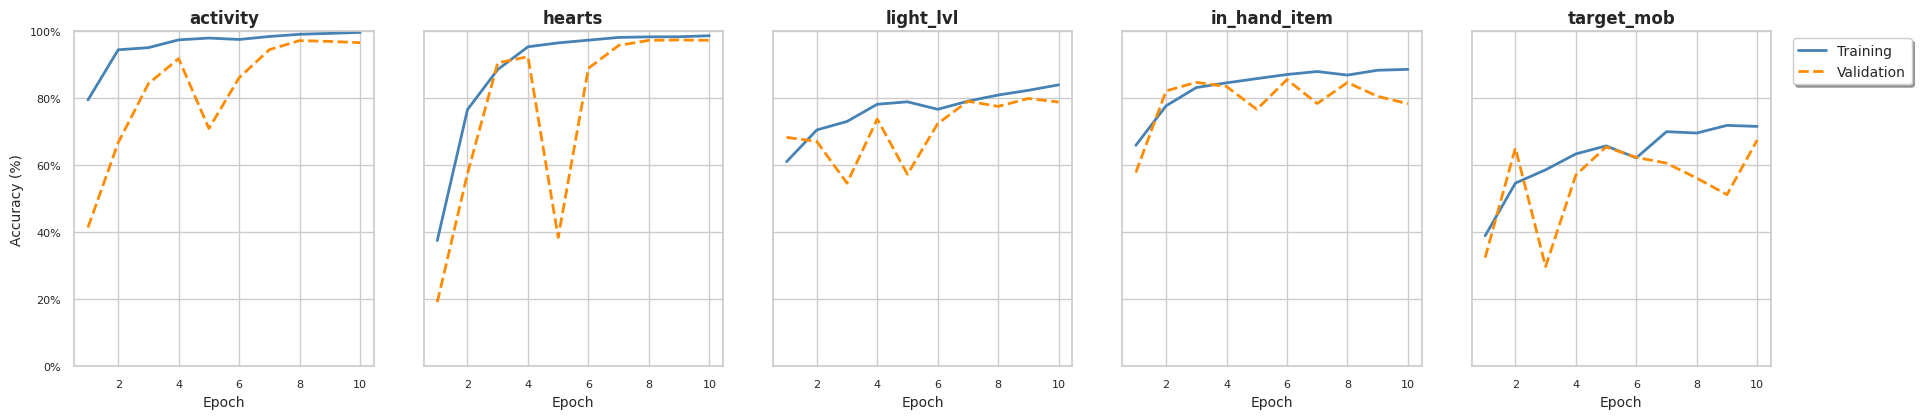

In [16]:
# Display accuracies V2
epochs = list(range(1, len(next(iter(training_accuracies.values()))) + 1))
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, len(training_accuracies), figsize=(20, 5), sharey=True)

for idx, (key, train_values) in enumerate(training_accuracies.items()):
    val_values = validation_accuracies[key]

    axs[idx].plot(epochs, train_values, label='Training', color='steelblue', linewidth=2)
    axs[idx].plot(epochs, val_values, label='Validation', color='darkorange', linestyle='--', linewidth=2)

    axs[idx].set_title(key, fontsize=12, fontweight='bold')
    axs[idx].set_xlabel('Epoch', fontsize=10)
    if idx == 0:
        axs[idx].set_ylabel('Accuracy (%)', fontsize=10)
    axs[idx].set_ylim(0, 1)
    axs[idx].tick_params(axis='both', labelsize=8)

    axs[idx].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))


plt.legend(['Training', 'Validation'], loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, shadow=True)
plt.tight_layout(pad=3.0)


plt.savefig("accuracy_trends_subplots.png", format='png', dpi=300, bbox_inches='tight')
plt.show()